<a href="https://colab.research.google.com/github/JairLeal157/MLDiabetes/blob/main/Experimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import joblib
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, make_scorer
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score





**1. Importacion de datos y exploracion basica de los datos**

importamos los datos e imprimiremos sus características junto a la forma del compartamiento de cada una de sus variables y sus correlacion


In [9]:
# Importamos los datos de csv en un dataframe de pandas
data= pd.read_csv("diabetes_prediction_dataset.csv")

# Columnas del dataframe
data.info()

# Ejemplo de los datos
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


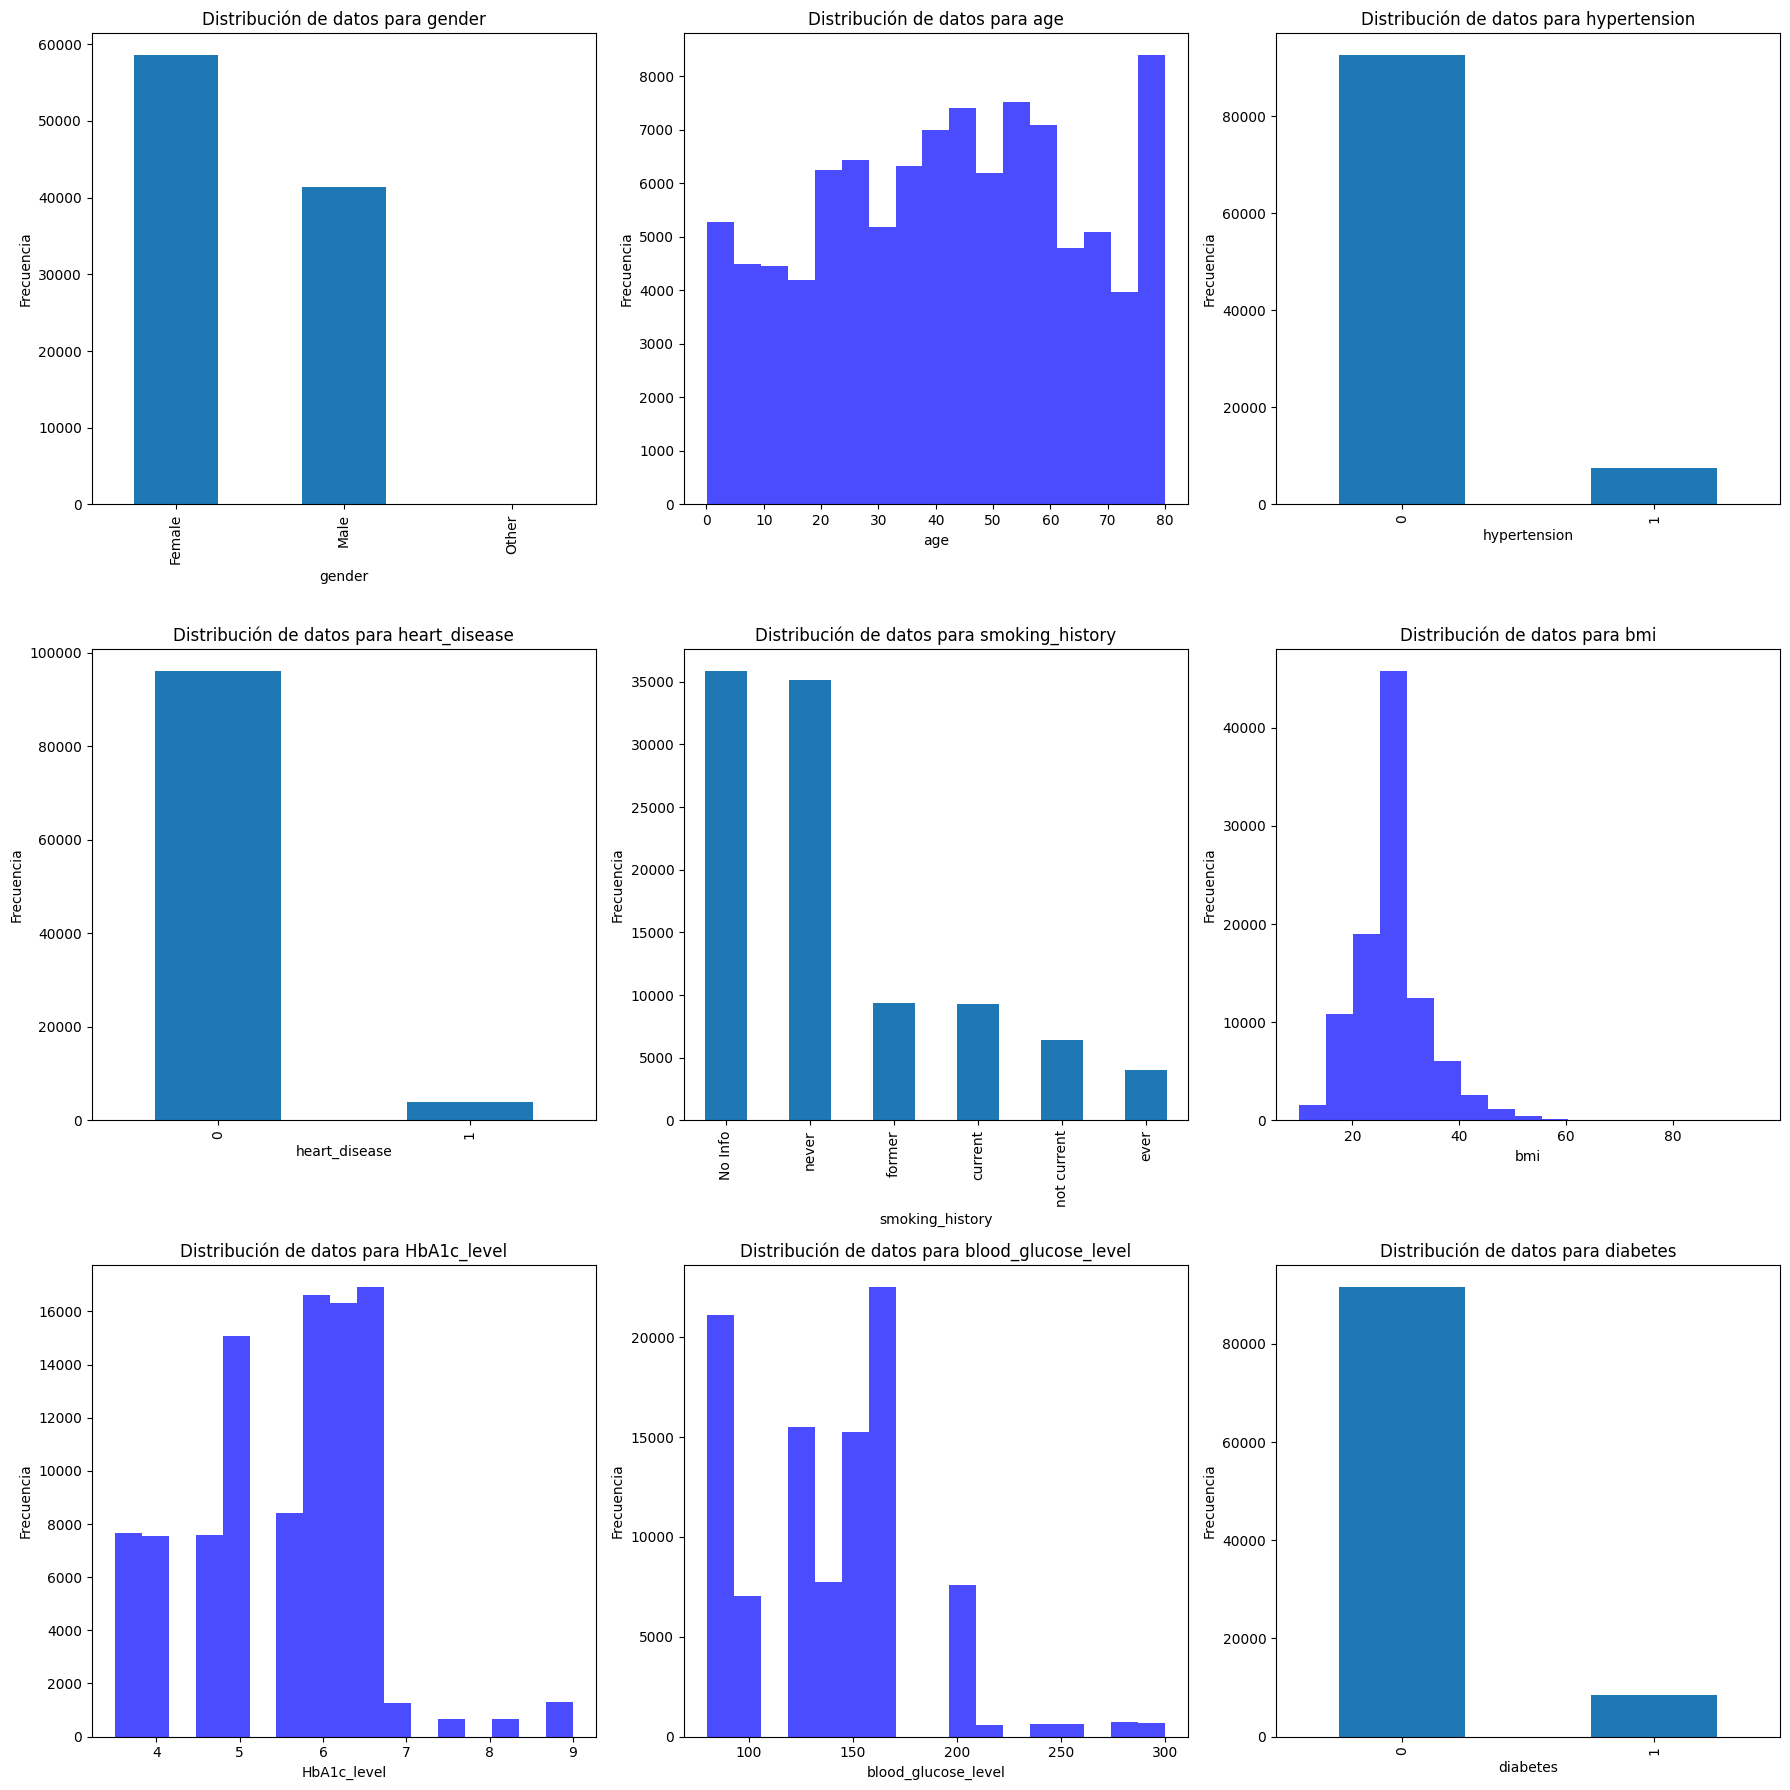

In [25]:
fig, axes = plt.subplots(3,3, figsize=(18,18))
axes = axes.ravel()
for i, columna in enumerate(data):
    ax = axes[i]
    if columna in ['gender','hypertension','heart_disease','smoking_history', 'diabetes']:     
        data[columna].value_counts().plot(kind='bar', ax = ax)
    else:
        N = len(data[columna])
        num_bins = int(1 + np.log2(N))
        data[columna].plot(kind='hist', bins=num_bins, color='blue', alpha=0.7, ax = ax)

    ax.set_title(f'Distribución de datos para {columna}')
    ax.set_xlabel(columna)
    ax.set_ylabel('Frecuencia')

# Mostrar el gráfico en pantalla
plt.tight_layout()
plt.show()

**2. Tratamiento de Datos: Conversión de Datos Categóricos a Numéricos**

Convertiremos datos categóricos en representaciones numéricas para su uso en modelos de aprendizaje automático.

In [10]:
# Creamos un encoder para la columna 'gender'
gender_encoder = OneHotEncoder(sparse=False)
gender_encoded = gender_encoder.fit_transform(data[['gender']])

# Creamos un encoder para la columna 'smoking_history'
smoking_history_encoder = OneHotEncoder(sparse=False)
smoking_history_encoded = smoking_history_encoder.fit_transform(data[['smoking_history']])

# Convertimos en DataFrames
gender_encoded_df = pd.DataFrame(gender_encoded, columns=gender_encoder.get_feature_names_out(['gender']))
smoking_history_encoded_df = pd.DataFrame(smoking_history_encoded, columns=smoking_history_encoder.get_feature_names_out(['smoking_history']))

# Eliminamos las columnas originales
data = data.drop(['gender', 'smoking_history'], axis=1)

# Concatenamos los DataFrames codificados 
data = pd.concat([data, gender_encoded_df, smoking_history_encoded_df], axis=1)

# Ejemplo de los datos
display(data.head())



c:\Users\jairl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\jairl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,54.0,0,0,27.32,6.6,80,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,28.0,0,0,27.32,5.7,158,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,36.0,0,0,23.45,5.0,155,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,76.0,1,1,20.14,4.8,155,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**2.1 Matriz de correlacion**


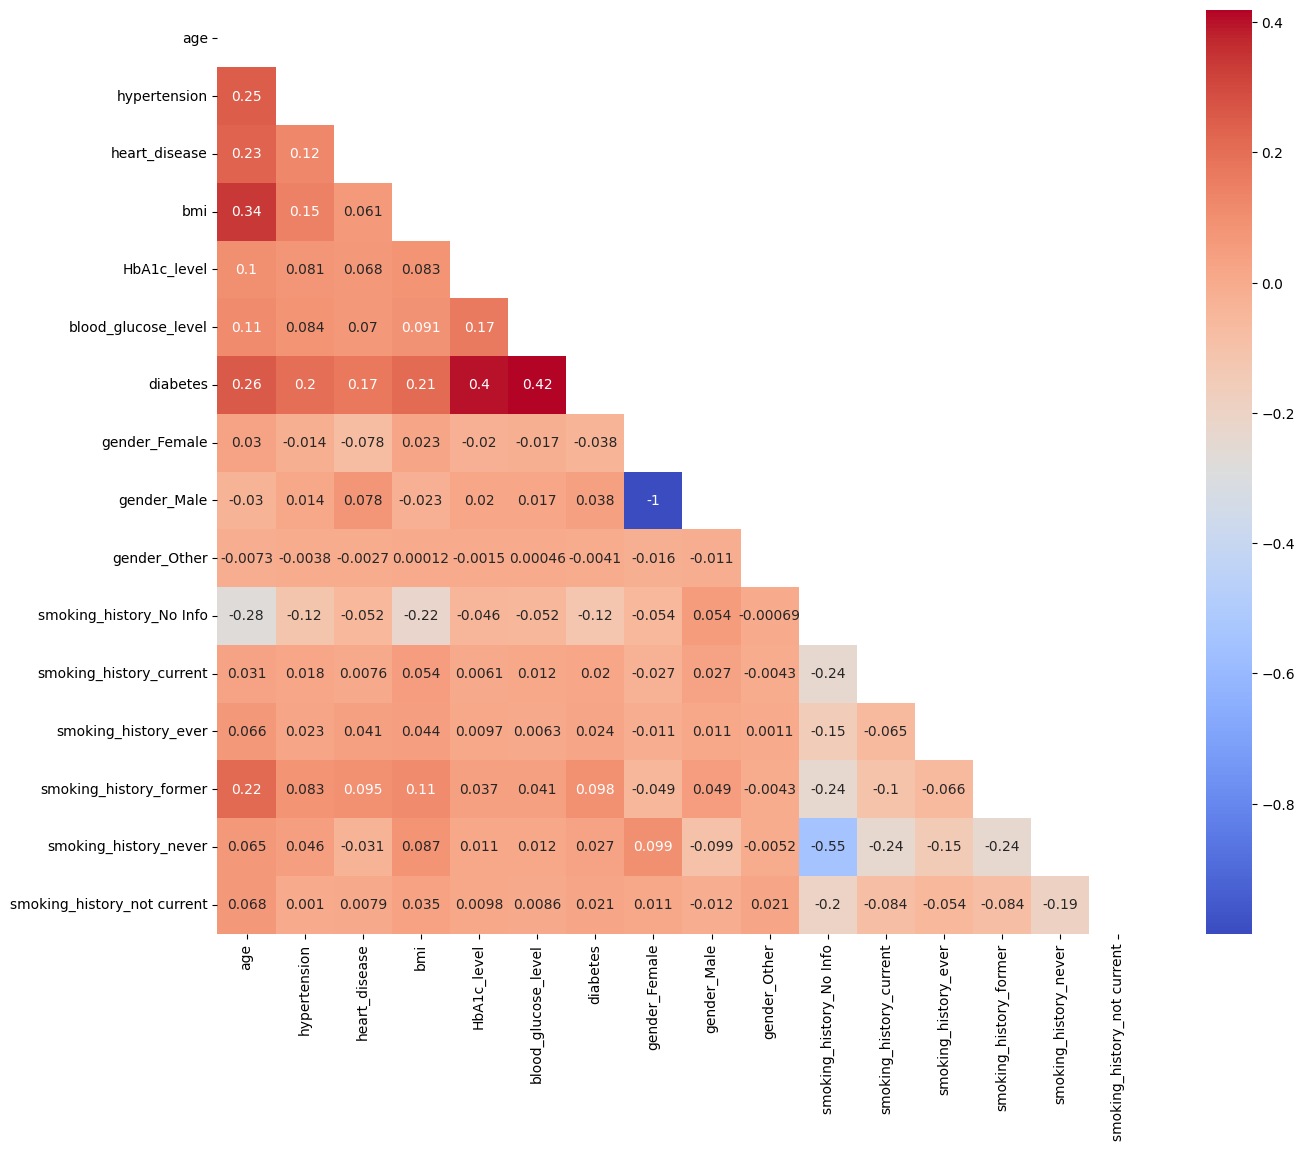

In [11]:
# definimos matriz de correlacion
corr = data.corr(method='pearson')
# Creamos una máscara que filtre la diagonal superior de la matriz (para ignorar duplicados)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
#generamos hotmap con seaborn
plt.figure(figsize=(15,12))
sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=True)
plt.show()


Analisis de valores de correlacion Negativa Altos  < -0.80
gender_Female y gender_Male: esta es claramente una relacion inversa ya que claramente si un paciente es hombre, no puede ser mujer, por ello indica una correlacion negativa perfecta

Analisis de valores de correlacion Negativa Medios  -0.4 < correlacion < -0.8
Smoking_history_no_Info y Smoking_history_Never: indica que hay una relación inversa moderada entre estas dos variables. Esto significa que si un paciente no tiene información sobre su historial de tabaquismo, es menos probable que nunca haya fumado. Es importante tener en cuenta que no podemos concluir que la falta de información sobre el historial de tabaquismo sea la causa directa de que un paciente haya fumado en el pasado o lo haga actualmente. Pueden haber otros factores que influyan en la relación entre estas dos variables.

Analisis de valores de correlacion media 0.4 < correlacion < 0.8
Diabetes y blood_glucose_level, HbA1c_leve: esta correlacion se peude explciar deido a que son medidas que se hacen en la ansagre para medir su nivel de azucar, existe una correlacion entre ellas, pero no indica siempre que por ello alla diabtes, pueden existir otros factores que influyen en la relacion de estas variables, como las comidas en las ultimas semanas.


**3. Particion de los datos para entrenamiento**

Separaremos los datos, siendo 70% de los datos para entrenamiento y 30% para validacion.

In [12]:
# Importamos las funciones de sklearn
from sklearn.model_selection import train_test_split

# Dividimos los datos en variables de entrada y salida
X = data.drop('diabetes', axis=1)
Y = data['diabetes']

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


**4. Uso de la tecnica de sobre-muestreo**

Como en nuestra variable objetivo existe un claro desbalance, usaremos la tecnica de sobre-muestreo para solucionarlo

In [8]:
#demostrar que el sobremuestreo arruina la distribucion de los datos
original_data = pd.read_csv("diabetes_prediction_dataset.csv")
X = original_data.drop('diabetes', axis=1)
Y = original_data['diabetes']
#variables categoricas y sus indices
for i, columna in enumerate(X):
    if X[columna].dtype == 'object':
        print(columna, i)
        
categorical_variable = [0, 4]
#sobremuestreo con smotenc
smote_nc = SMOTENC(categorical_features=categorical_variable, random_state=42, sampling_strategy='minority')
X_resampled, y_resampled = smote_nc.fit_resample(X, Y)
data_sobremuestreo = pd.concat([X_resampled, y_resampled], axis=1)


gender 0
smoking_history 4


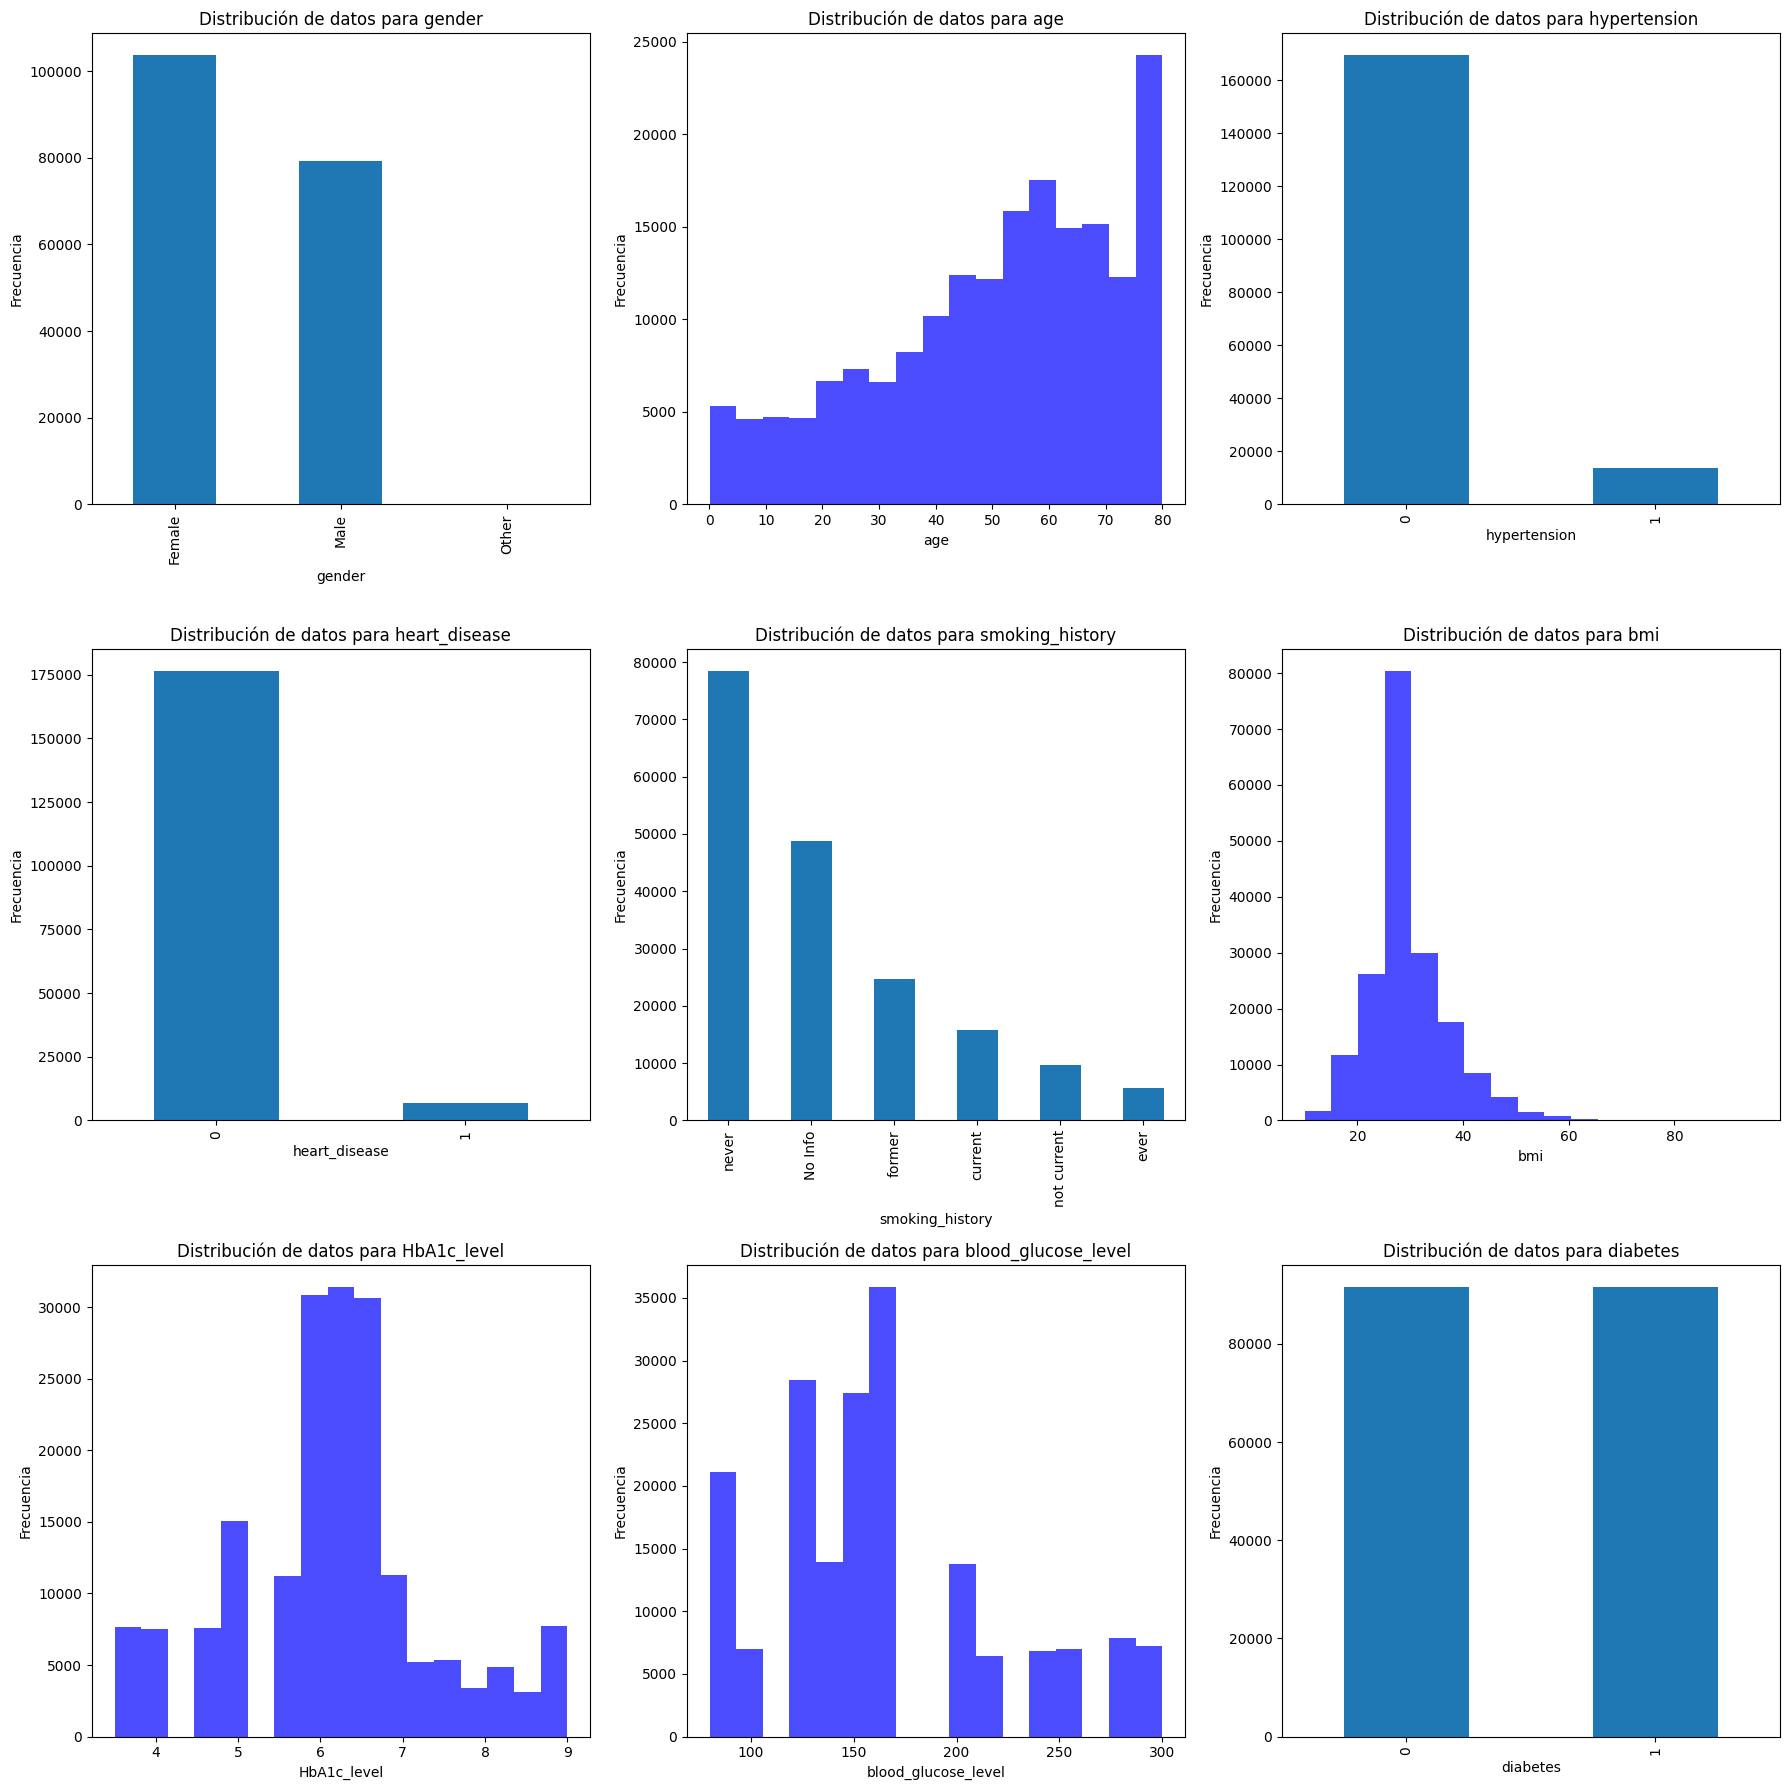

In [30]:
fig, axes = plt.subplots(3,3, figsize=(18,18))
axes = axes.ravel()
for i, columna in enumerate(data_sobremuestreo):
    ax = axes[i]
    if columna in ['gender','hypertension','heart_disease','smoking_history', 'diabetes']:
        data_sobremuestreo[columna].value_counts().plot(kind='bar', ax = ax)
    else:
        N = len(data[columna])
        num_bins = int(1 + np.log2(N))
        data_sobremuestreo[columna].plot(kind='hist', bins=num_bins, color='blue', alpha=0.7, ax = ax)

    ax.set_title(f'Distribución de datos para {columna}')
    ax.set_xlabel(columna)
    ax.set_ylabel('Frecuencia')

# Mostrar el gráfico en pantalla
plt.tight_layout()
plt.show()

**5. Entrenamiento y seleccion de los mejores hiperparametros de cada modelo**

Se va a entrenar a cada modelo, utilizando diferentes valores para sus hiperparametros, usando como metodologia de validacion k-folds. 
Para evaluar cuales son los mejores hiperparametros de cada modelo se evaluara su score, comparandolo con el los datos de entrenamiento clasico y con el de test, de esta forma tambien evaluaremos posibles casos de sobre-entrenamiento.
Modelos:

    -Redes neuronales 

    -Gradient boosting tree 

    -SVM 

**5.1 Redes neuronales**

In [1]:
neuronas_vector = [4, 7, 10] # Vector con el número de neuronas a probar
capas_vector = [1, 1, 3] # Vector con el número de capas a probar
plt.figure(figsize=(18, 5))
scoring_for_kfolds= {
    'f1_score': make_scorer(f1_score),
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}
table = pd.DataFrame()
for i, capas in enumerate(capas_vector):
    train_scores = {
        'f1_score': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    cross_val_scores = {
        'f1_score': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    test_scores = {
        'f1_score': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    for neuronas in neuronas_vector:
        model = MLPClassifier(
            hidden_layer_sizes=(neuronas,)*capas,
            activation='relu',  # Función de activación ReLU
            batch_size=64, # Tamaño del minibatch
            max_iter=1000 # Número máximo de iteraciones
        )
        #Entrenamiento del modelo
        model.fit(X_train, Y_train)
        # Calcula el score en el conjunto de entrenamiento
        y_train_pred = model.predict(X_train)
        train_scores['f1_score'].append(f1_score(Y_train, y_train_pred))
        train_scores['accuracy'].append(accuracy_score(Y_train, y_train_pred))
        train_scores['precision'].append(precision_score(Y_train, y_train_pred))
        train_scores['recall'].append(recall_score(Y_train, y_train_pred))
        
        
        #Entrenamiento del modelo con validación cruzada
        k = 5 # Número de folds
        stratified_k_fold = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
        n_jobs =  6 # Número de procesos en paralelo
        cv_scores = cross_validate(model, X_train, Y_train, cv=stratified_k_fold, scoring=scoring_for_kfolds, n_jobs=n_jobs)
        # Calcula el score en el conjunto de entrenamiento
        cross_val_scores['f1_score'].append(cv_scores['test_f1_score'].mean())
        cross_val_scores['accuracy'].append(cv_scores['test_accuracy'].mean())
        cross_val_scores['precision'].append(cv_scores['test_precision'].mean())
        cross_val_scores['recall'].append(cv_scores['test_recall'].mean())
        
        # Calcula el f1_score en el conjunto de prueba
        y_test_pred = model.predict(X_test)
        test_scores['f1_score'].append(f1_score(Y_test, y_test_pred))
        test_scores['accuracy'].append(accuracy_score(Y_test, y_test_pred))
        test_scores['precision'].append(precision_score(Y_test, y_test_pred))
        test_scores['recall'].append(recall_score(Y_test, y_test_pred))
        
    plt.subplot(1, 3, i+1)
    plt.plot(neuronas_vector,  train_scores['f1_score'], label='Entrenamiento', marker='o')
    plt.plot(neuronas_vector, cross_val_scores['f1_score'], label='Validación Cruzada', marker='o')
    plt.plot(neuronas_vector, test_scores['f1_score'], label='Prueba', marker='o')
    plt.xlabel('Número de Neuronas')
    plt.ylabel('f1-score')
    plt.title(f'f1-score vs Número de Neuronas para {capas} capas ocultas')
    plt.legend()
    plt.grid()
    
    table = pd.concat([table, pd.DataFrame({
        'numero de capas': [capas]*len(neuronas_vector),
        'Número de Neuronas': neuronas_vector,
        'f1-score entrenamiento': train_scores['f1_score'],
        'accuracy entrenamiento': train_scores['accuracy'],
        'precision entrenamiento': train_scores['precision'],
        'recall entrenamiento': train_scores['recall'],
        'f1-score validación cruzada': cross_val_scores['f1_score'],
        'accuracy validación cruzada': cross_val_scores['accuracy'],
        'precision validación cruzada': cross_val_scores['precision'],
        'recall validación cruzada': cross_val_scores['recall'],
        'f1-score prueba': test_scores['f1_score'],
        'accuracy prueba': test_scores['accuracy'],
        'precision prueba': test_scores['precision'],
        'recall prueba': test_scores['recall']
    })], axis=0)
plt.tight_layout()
plt.show()
display(table)

NameError: name 'make_scorer' is not defined

Intentando maxificar el F1_Score y minimizar la diferencia entre los tres puntajes y la complejidad del modelo. el mejor modelo de redes neuronales tiene como hiperparametros :

Neuronas =10

Capas = 2

mini-batch = 64

funcion-activacion ReLu

maximo-iteraciones = 1000


**5.1.1 Metricas**


In [13]:
model_red_neuronal = MLPClassifier(
        hidden_layer_sizes=(10)*2,  # 1 capas oculta con 10 neuronas
        activation='relu',  # Función de activación ReLU
        batch_size=64, # Tamaño del minibatch
        max_iter=1000, # Número máximo de iteraciones
    )
#Entrenamiento del modelo
model_red_neuronal.fit(X_train, Y_train)
y_test_pred_red_neuronal = model.predict(X_test)


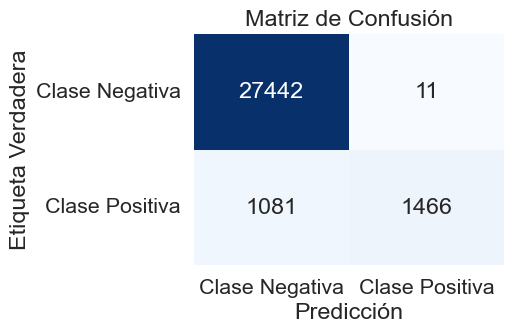

In [14]:
cm = confusion_matrix(Y_test, y_test_pred_red_neuronal)
# Define las etiquetas para las clases
class_names = ["Clase Negativa", "Clase Positiva"]

# Crea una figura y ejes para el mapa de calor
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.4)  # Ajusta el tamaño de la fuente

# Crea el mapa de calor
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)

# Etiqueta los ejes
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
# Añade el título
plt.title('Matriz de Confusión')
# Muestra el mapa de calor
plt.show()

In [15]:
# Define las etiquetas verdaderas y las predicciones
y_true = Y_test  # Etiquetas verdaderas
y_pred = y_test_pred_red_neuronal  # Predicciones del modelo

# Calcula la precisión
precision_red_neuronal = precision_score(y_true, y_pred)

# Calcula la sensibilidad (recall)
sensibilidad_red_neuronal = recall_score(y_true, y_pred)

# Calcula la puntuación F1
f1_red_neuronal = f1_score(y_true, y_pred)

# Calcula la exactitud (accuracy)
exactitud_red_neuronal = accuracy_score(y_true, y_pred)

# Calcula la especificidad
# Especificidad es la proporción de verdaderos negativos (TN) en relación con todos los negativos (TN + FP)
especificidad_red_neuronal = sum((y_true == 0) & (y_pred == 0)) / sum(y_true == 0)

# Imprime las métricas
print(f'Precisión: {precision_red_neuronal:.2f}')
print(f'Sensibilidad (Recall): {sensibilidad_red_neuronal:.2f}')
print(f'Puntuación F1: {f1_red_neuronal:.2f}')
print(f'Accuracy: {exactitud_red_neuronal:.2f}')
print(f'Especificidad: {especificidad_red_neuronal:.2f}')

Precisión: 0.99
Sensibilidad (Recall): 0.58
Puntuación F1: 0.73
Exactitud: 0.96
Especificidad: 1.00


#analisis metricas


**5.2 Gradient boosting tree**

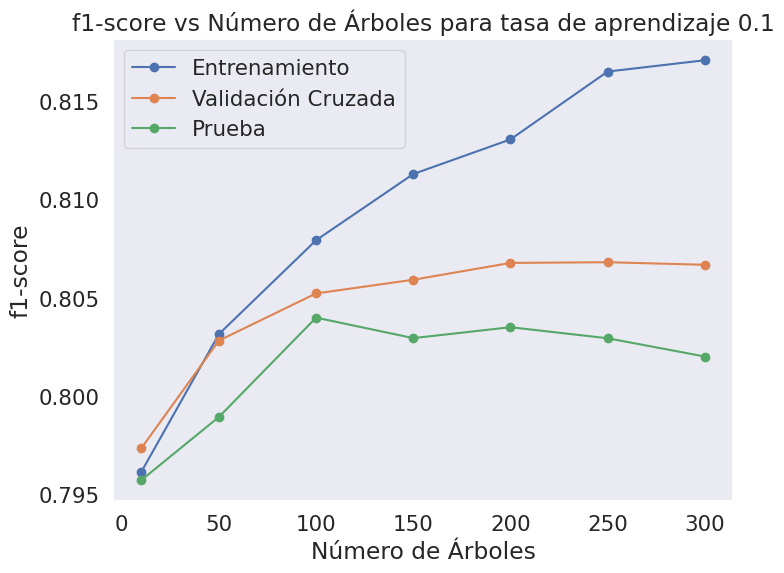

   Número de Neuronas  Entrenamiento  Validación Cruzada    Prueba
0                  10       0.796158            0.797363  0.795745
1                  50       0.803175            0.802846  0.798963
2                 100       0.807948            0.805243  0.804013
3                 150       0.811313            0.805938  0.802971
4                 200       0.813074            0.806794  0.803526
5                 250       0.816524            0.806829  0.802964
6                 300       0.817098            0.806700  0.802035


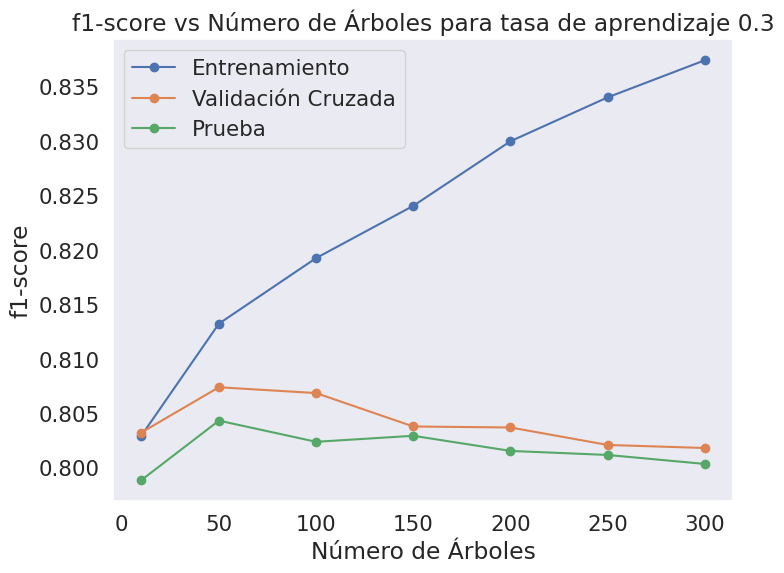

   Número de Neuronas  Entrenamiento  Validación Cruzada    Prueba
0                  10       0.802936            0.803241  0.798868
1                  50       0.813236            0.807401  0.804338
2                 100       0.819251            0.806866  0.802395
3                 150       0.824047            0.803801  0.802947
4                 200       0.829972            0.803710  0.801560
5                 250       0.833997            0.802108  0.801188
6                 300       0.837403            0.801827  0.800365


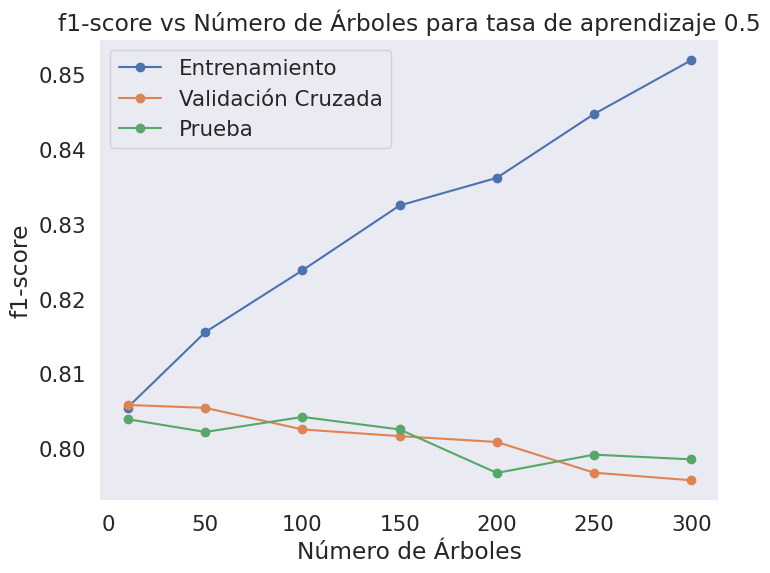

   Número de Neuronas  Entrenamiento  Validación Cruzada    Prueba
0                  10       0.805487            0.805831  0.803926
1                  50       0.815572            0.805441  0.802216
2                 100       0.823851            0.802551  0.804228
3                 150       0.832525            0.801657  0.802554
4                 200       0.836220            0.800875  0.796733
5                 250       0.844760            0.796769  0.799182
6                 300       0.851958            0.795755  0.798551


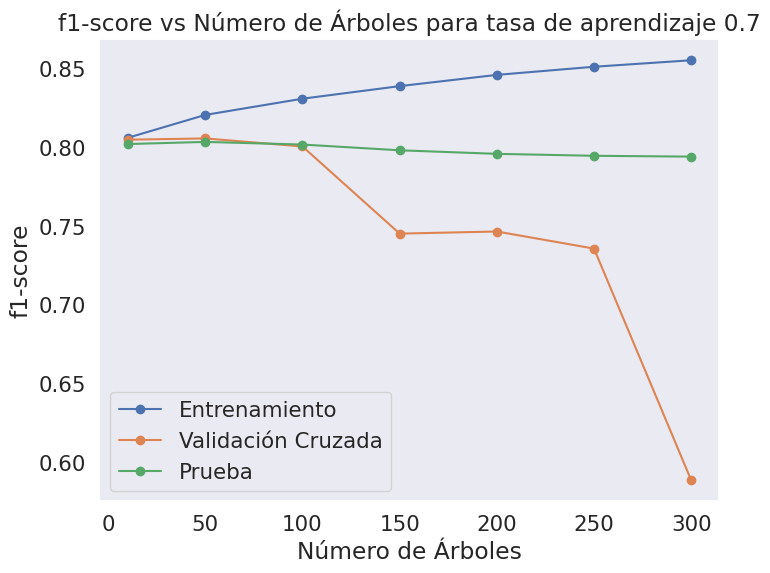

   Número de Neuronas  Entrenamiento  Validación Cruzada    Prueba
0                  10       0.806083            0.804921  0.802147
1                  50       0.820679            0.805721  0.803510
2                 100       0.830987            0.800610  0.801826
3                 150       0.838982            0.745189  0.798178
4                 200       0.846132            0.746534  0.795918
5                 250       0.851303            0.735672  0.794681
6                 300       0.855439            0.588350  0.794157


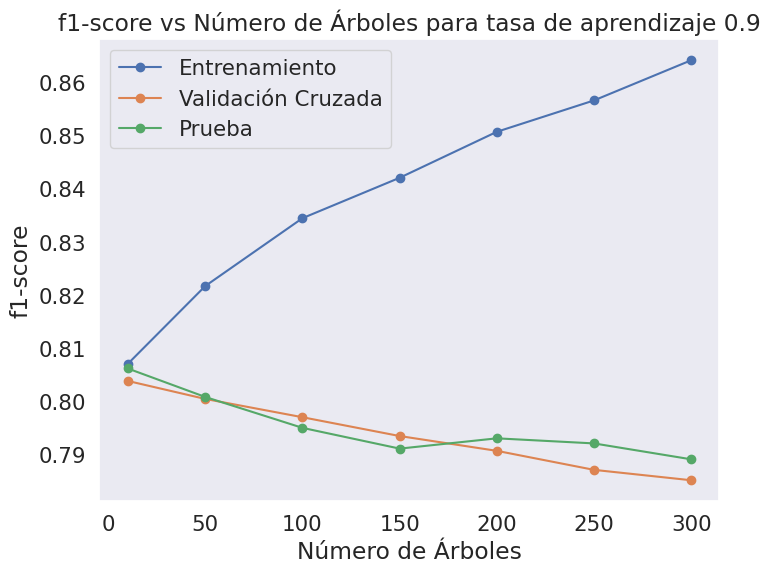

   Número de Neuronas  Entrenamiento  Validación Cruzada    Prueba
0                  10       0.807014            0.803856  0.806205
1                  50       0.821718            0.800457  0.800826
2                 100       0.834488            0.797014  0.795011
3                 150       0.842095            0.793473  0.791105
4                 200       0.850750            0.790687  0.793042
5                 250       0.856659            0.787105  0.792084
6                 300       0.864221            0.785150  0.789092


In [197]:
numero_de_arboles_vector = [10, 50, 100, 150, 200, 250, 300] # Vector con el número de árboles a probar
tasa_aprendizaje_vector = [0.1, 0.3, 0.5, 0.7, 0.9] # Vector con la tasa de aprendizaje a probar
for tasa_aprendizaje in tasa_aprendizaje_vector:
    train_f1_scores = []
    cross_val_f1_scores = []
    test_f1_scores = []
    for numero_de_arboles in numero_de_arboles_vector:
        model = GradientBoostingClassifier(max_features=8,
                                           n_estimators=numero_de_arboles,
                                           learning_rate=tasa_aprendizaje,
                                           random_state=42)
        #Entrenamiento del modelo
        model.fit(X_train, Y_train)
        # Calcula el f1-score en el conjunto de entrenamiento
        y_train_pred = model.predict(X_train)
        train_f1_score = f1_score(Y_train, y_train_pred)
        train_f1_scores.append(train_f1_score)

        #Entrenamiento del modelo con validación cruzada
        k = 5 # Número de folds
        stratified_k_fold = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
        n_jobs =  6 # Número de procesos en paralelo
        cv_scores = cross_val_score(model, X_train, Y_train, cv= stratified_k_fold, scoring=make_scorer(f1_score), n_jobs=n_jobs)
        # Calcula el f1_score en el conjunto de entrenamiento
        cross_f1_score = cv_scores.mean()
        cross_val_f1_scores.append(cross_f1_score)

        # Calcula el f1_score en el conjunto de prueba
        y_test_pred = model.predict(X_test)
        test_f1_score = f1_score(Y_test, y_test_pred)
        test_f1_scores.append(test_f1_score)
        
        
    plt.figure(figsize=(8, 6))
    plt.plot(numero_de_arboles_vector, train_f1_scores, label='Entrenamiento', marker='o')
    plt.plot(numero_de_arboles_vector, cross_val_f1_scores, label='Validación Cruzada', marker='o')
    plt.plot(numero_de_arboles_vector, test_f1_scores, label='Prueba', marker='o')
    plt.xlabel('Número de Árboles')
    plt.ylabel('f1-score')
    plt.title(f'f1-score vs Número de Árboles para tasa de aprendizaje {tasa_aprendizaje}')
    plt.legend()
    plt.grid()
    plt.show()
    
    table = pd.DataFrame({
    'Número de Neuronas': numero_de_arboles_vector,
    'Entrenamiento': train_f1_scores,
    'Validación Cruzada': cross_val_f1_scores,
    'Prueba': test_f1_scores})
    print(table)
        

Intentando maxificar el F1_Score y minimizar la diferencia entre los tres puntajes y la complejidad del modelo. el mejor modelo de Gradient boosting tree tiene como hiperparametros :

maximo numero de variables = 8

numero de arboles = 100

taza de aprendizaje = 0.1

random_state = 42

**5.2.1 Metricas**

In [16]:
model_arboles = GradientBoostingClassifier(max_features=8,
                                           n_estimators=100,
                                           learning_rate=0.1,
                                           random_state=42)
#Entrenamiento del modelo
model_arboles.fit(X_train, Y_train)
y_test_pred_arboles = model_arboles.predict(X_test)

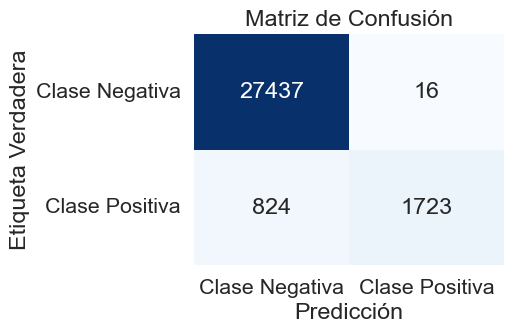

In [17]:
cm = confusion_matrix(Y_test, y_test_pred_arboles)
# Define las etiquetas para las clases
class_names = ["Clase Negativa", "Clase Positiva"]

# Crea una figura y ejes para el mapa de calor
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.4)  # Ajusta el tamaño de la fuente

# Crea el mapa de calor
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)

# Etiqueta los ejes
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
# Añade el título
plt.title('Matriz de Confusión')
# Muestra el mapa de calor
plt.show()

In [18]:
# Define las etiquetas verdaderas y las predicciones
y_true = Y_test  # Etiquetas verdaderas
y_pred = y_test_pred_arboles  # Predicciones del modelo

# Calcula la precisión
precision_arboles = precision_score(y_true, y_pred)

# Calcula la sensibilidad (recall)
sensibilidad_arboles = recall_score(y_true, y_pred)

# Calcula la puntuación F1
f1_arboles = f1_score(y_true, y_pred)

# Calcula la exactitud (accuracy)
exactitud_arboles = accuracy_score(y_true, y_pred)

# Calcula la especificidad
# Especificidad es la proporción de verdaderos negativos (TN) en relación con todos los negativos (TN + FP)
especificidad_arboles = sum((y_true == 0) & (y_pred == 0)) / sum(y_true == 0)

# Imprime las métricas
print(f'Precisión: {precision_arboles:.2f}')
print(f'Sensibilidad (Recall): {sensibilidad_arboles:.2f}')
print(f'Puntuación F1: {f1_arboles:.2f}')
print(f'Exactitud: {exactitud_arboles:.2f}')
print(f'Especificidad: {especificidad_arboles:.2f}')

Precisión: 0.99
Sensibilidad (Recall): 0.68
Puntuación F1: 0.80
Exactitud: 0.97
Especificidad: 1.00


**5.3 SVM**

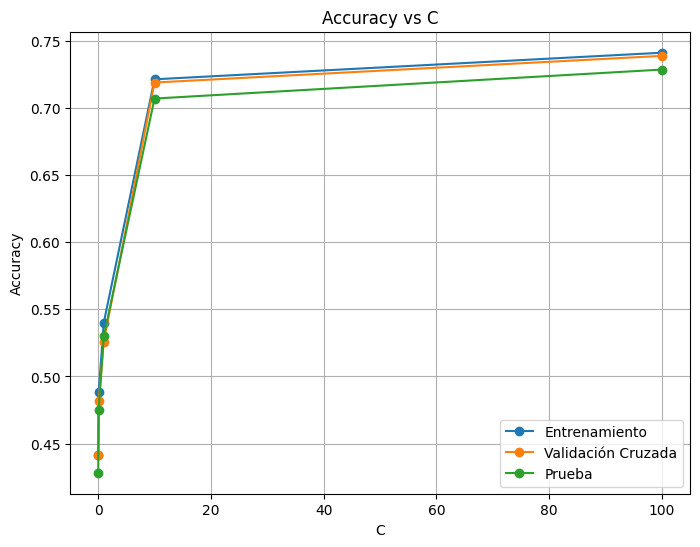

        C  Entrenamiento  Validación Cruzada    Prueba
0    0.01       0.441215            0.441193  0.428263
1    0.10       0.488511            0.481510  0.475307
2    1.00       0.540150            0.526015  0.529870
3   10.00       0.721382            0.718978  0.707045
4  100.00       0.741185            0.738835  0.728628


In [6]:
c_vector = [0.01, 0.1, 1, 10, 100] # Vector con los valores de C a probar
train_f1_scores = []
cross_val_f1_scores = []
test_f1_scores = []
for c in c_vector:
    model = SVC(C=c, kernel='rbf', random_state=42)
    #Entrenamiento del modelo
    model.fit(X_train, Y_train)
    # Calcula el f1-score en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    train_f1_score = f1_score(Y_train, y_train_pred)
    train_f1_scores.append(train_f1_score)

    #Entrenamiento del modelo con validación cruzada
    k = 5 # Número de folds
    stratified_k_fold = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
    n_jobs =  6 # Número de procesos en paralelo
    cv_scores = cross_val_score(model, X_train, Y_train, cv= stratified_k_fold, scoring=make_scorer(f1_score), n_jobs=n_jobs)
    # Calcula el f1_score en el conjunto de entrenamiento
    cross_f1_score = cv_scores.mean()
    cross_val_f1_scores.append(cross_f1_score)

    # Calcula el f1_score en el conjunto de prueba
    y_test_pred = model.predict(X_test)
    test_f1_score = f1_score(Y_test, y_test_pred)
    test_f1_scores.append(test_f1_score)
    
plt.figure(figsize=(8, 6))
plt.plot(c_vector, train_f1_scores, label='Entrenamiento', marker='o')
plt.plot(c_vector, cross_val_f1_scores, label='Validación Cruzada', marker='o')
plt.plot(c_vector, test_f1_scores, label='Prueba', marker='o')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs C')
plt.legend()
plt.grid()
plt.show()

table = pd.DataFrame({
'C': c_vector,
'Entrenamiento': train_f1_scores,
'Validación Cruzada': cross_val_f1_scores,
'Prueba': test_f1_scores})
print(table)

Intentando maxificar el F1_Score y minimizar la diferencia entre los tres puntajes y la complejidad del modelo. el mejor modelo de SVM tiene como hiperparametros :
kernel = 'rbf'
Permabilidad(C) = 10

**5.3.1 Metricas**

In [19]:
model_svm = SVC(C=10, kernel='rbf', random_state=42)

#Entrenamiento del modelo
model_svm.fit(X_train, Y_train)
y_test_pred_svm = model_svm.predict(X_test)

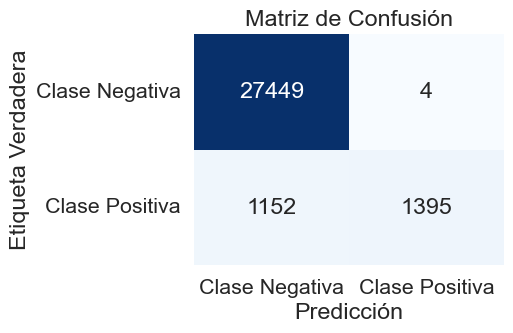

In [9]:
cm = confusion_matrix(Y_test, y_test_pred_svm)
# Define las etiquetas para las clases
class_names = ["Clase Negativa", "Clase Positiva"]

# Crea una figura y ejes para el mapa de calor
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.4)  # Ajusta el tamaño de la fuente

# Crea el mapa de calor
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)

# Etiqueta los ejes
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
# Añade el título
plt.title('Matriz de Confusión')
# Muestra el mapa de calor
plt.show()

In [20]:
# Define las etiquetas verdaderas y las predicciones
y_true = Y_test  # Etiquetas verdaderas
y_pred = y_test_pred_svm  # Predicciones del modelo

# Calcula la precisión
precision_svm = precision_score(y_true, y_pred)
# Calcula la sensibilidad (recall)
sensibilidad_svm = recall_score(y_true, y_pred)

# Calcula la puntuación F1
f1_svm = f1_score(y_true, y_pred)

# Calcula la exactitud (accuracy)
exactitud_svm = accuracy_score(y_true, y_pred)

# Calcula la especificidad
# Especificidad es la proporción de verdaderos negativos (TN) en relación con todos los negativos (TN + FP)
especificidad_svm = sum((y_true == 0) & (y_pred == 0)) / sum(y_true == 0)

# Imprime las métricas
print(f'Precisión: {precision_svm:.2f}')
print(f'Sensibilidad (Recall): {sensibilidad_svm:.2f}')
print(f'Puntuación F1: {f1_svm:.2f}')
print(f'Exactitud: {exactitud_svm:.2f}')
print(f'Especificidad: {especificidad_svm:.2f}')

Precisión: 1.00
Sensibilidad (Recall): 0.55
Puntuación F1: 0.71
Exactitud: 0.96
Especificidad: 1.00


**5.4 Eleccion mejor modelo**

In [21]:
#Tabla comparativa de modelos usando sus métricas

# Creamos un DataFrame con las métricas de los modelos

df = pd.DataFrame({
    'Modelo': ['Red Neuronal', 'Árboles de Decisión', 'SVM'],
    'Precisión': [precision_red_neuronal, precision_arboles, precision_svm],
    'Sensibilidad': [sensibilidad_red_neuronal, sensibilidad_arboles, sensibilidad_svm],
    'Puntuación F1': [f1_red_neuronal, f1_arboles, f1_svm],
    'Exactitud': [exactitud_red_neuronal, exactitud_arboles, exactitud_svm],
    'Especificidad': [especificidad_red_neuronal, especificidad_arboles, especificidad_svm]
})

# Mostramos el DataFrame
display(df)


,Modelo,Precisión,Sensibilidad,Puntuación F1,Exactitud,Especificidad
0,Red Neuronal,0.992552,0.575579,0.728628,0.963600,0.999599
1,Árboles de Decisión,0.990799,0.676482,0.804013,0.972000,0.999417
2,SVM,0.997141,0.547703,0.707045,0.961467,0.999854


#eleccion mejor modelo